In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/9ae6552353.jpg
/kaggle/input/gan-getting-started/monet_jpg/e37407c747.jpg
/kaggle/input/gan-getting-started/monet_jpg/79292e1434.jpg
/kaggle/input/gan-getting-started/monet_jpg/5c79cfe0b3.jpg
/kaggle/input/gan-getting-started/monet_jpg/281b73fb5e.jpg
/kaggle/input/gan-getting-started/monet_jpg/16dabe418c.jpg
/kaggle/input/gan-getting-started/monet_jpg/7cb36714d0.jpg
/kaggle/input/gan-getting-started/monet_jpg/8e5ff15568.jpg
/kaggle/input/gan-getting-started/monet_jpg/3eaef3ee43.jpg
/kaggle/input/gan-getting-started/monet_jpg/ad0101d010.jpg
/kaggle/input/gan-getting-started/monet_jpg/d729785cb8.jpg
/kaggle/input/gan-getting-started/monet_jpg/463835bbc6.jpg
/kaggle/input/gan-getting-started/monet_jpg/bbc5ac4564.jpg
/kaggle/input/gan-getting-started/monet_jpg/52aed0f943.jpg
/kaggle/input/gan-getting-started/monet_jpg/e3112413b1.jpg
/kaggle/input/gan-getting-started/monet_jpg/23f0fbd77e.jpg
/kaggle/input/gan-getting-started/monet_jpg/990ed28f62.j

/kaggle/input/gan-getting-started/photo_jpg/7500111c43.jpg
/kaggle/input/gan-getting-started/photo_jpg/b3bfca1f8b.jpg
/kaggle/input/gan-getting-started/photo_jpg/442465d291.jpg
/kaggle/input/gan-getting-started/photo_jpg/efbfcfe793.jpg
/kaggle/input/gan-getting-started/photo_jpg/f6b61559e0.jpg
/kaggle/input/gan-getting-started/photo_jpg/dc549bebc4.jpg
/kaggle/input/gan-getting-started/photo_jpg/f46478e139.jpg
/kaggle/input/gan-getting-started/photo_jpg/276ee4b14f.jpg
/kaggle/input/gan-getting-started/photo_jpg/cac056399a.jpg
/kaggle/input/gan-getting-started/photo_jpg/7d33e5e3ac.jpg
/kaggle/input/gan-getting-started/photo_jpg/52592fe2c6.jpg
/kaggle/input/gan-getting-started/photo_jpg/f67f1708b6.jpg
/kaggle/input/gan-getting-started/photo_jpg/4e341f8891.jpg
/kaggle/input/gan-getting-started/photo_jpg/2c64a2295e.jpg
/kaggle/input/gan-getting-started/photo_jpg/db0ecb48c4.jpg
/kaggle/input/gan-getting-started/photo_jpg/7293694fa1.jpg
/kaggle/input/gan-getting-started/photo_jpg/3b465f08bf.j

/kaggle/input/gan-getting-started/photo_jpg/f7c78a4eef.jpg
/kaggle/input/gan-getting-started/photo_jpg/ae97673634.jpg
/kaggle/input/gan-getting-started/photo_jpg/e8a6213a64.jpg
/kaggle/input/gan-getting-started/photo_jpg/649df99535.jpg
/kaggle/input/gan-getting-started/photo_jpg/bcae56fbed.jpg
/kaggle/input/gan-getting-started/photo_jpg/f0e139a901.jpg
/kaggle/input/gan-getting-started/photo_jpg/0945008455.jpg
/kaggle/input/gan-getting-started/photo_jpg/e975867ee1.jpg
/kaggle/input/gan-getting-started/photo_jpg/95d4cb8eca.jpg
/kaggle/input/gan-getting-started/photo_jpg/dfbd52ecf5.jpg
/kaggle/input/gan-getting-started/photo_jpg/e7fd336c2e.jpg
/kaggle/input/gan-getting-started/photo_jpg/f58ec475cf.jpg
/kaggle/input/gan-getting-started/photo_jpg/3e0479c7a4.jpg
/kaggle/input/gan-getting-started/photo_jpg/b664354223.jpg
/kaggle/input/gan-getting-started/photo_jpg/f09c772bcc.jpg
/kaggle/input/gan-getting-started/photo_jpg/2f9d43719d.jpg
/kaggle/input/gan-getting-started/photo_jpg/2f5081e946.j

/kaggle/input/gan-getting-started/photo_jpg/e068928755.jpg
/kaggle/input/gan-getting-started/photo_jpg/0e2610ef33.jpg
/kaggle/input/gan-getting-started/photo_jpg/fc16c59788.jpg
/kaggle/input/gan-getting-started/photo_jpg/07ea3a38d2.jpg
/kaggle/input/gan-getting-started/photo_jpg/58d3d98397.jpg
/kaggle/input/gan-getting-started/photo_jpg/f98627c542.jpg
/kaggle/input/gan-getting-started/photo_jpg/9c564000e7.jpg
/kaggle/input/gan-getting-started/photo_jpg/2ce4fe7434.jpg
/kaggle/input/gan-getting-started/photo_jpg/16cd6cbc68.jpg
/kaggle/input/gan-getting-started/photo_jpg/4d42605a8b.jpg
/kaggle/input/gan-getting-started/photo_jpg/38d5379f18.jpg
/kaggle/input/gan-getting-started/photo_jpg/83cf828aa6.jpg
/kaggle/input/gan-getting-started/photo_jpg/880c9f0f1c.jpg
/kaggle/input/gan-getting-started/photo_jpg/62ada6e480.jpg
/kaggle/input/gan-getting-started/photo_jpg/bc320f44ee.jpg
/kaggle/input/gan-getting-started/photo_jpg/129823154f.jpg
/kaggle/input/gan-getting-started/photo_jpg/ba57ad5d60.j

/kaggle/input/gan-getting-started/photo_jpg/d97bbd8692.jpg
/kaggle/input/gan-getting-started/photo_jpg/6915fdb4e2.jpg
/kaggle/input/gan-getting-started/photo_jpg/8d373e4f08.jpg
/kaggle/input/gan-getting-started/photo_jpg/47100a9939.jpg
/kaggle/input/gan-getting-started/photo_jpg/83b450115e.jpg
/kaggle/input/gan-getting-started/photo_jpg/696f56514d.jpg
/kaggle/input/gan-getting-started/photo_jpg/3316c8daed.jpg
/kaggle/input/gan-getting-started/photo_jpg/a89c8773ae.jpg
/kaggle/input/gan-getting-started/photo_jpg/7c9af80795.jpg
/kaggle/input/gan-getting-started/photo_jpg/70c4ba13c5.jpg
/kaggle/input/gan-getting-started/photo_jpg/714de5bcda.jpg
/kaggle/input/gan-getting-started/photo_jpg/a546e53fbe.jpg
/kaggle/input/gan-getting-started/photo_jpg/2c060d43db.jpg
/kaggle/input/gan-getting-started/photo_jpg/b743015621.jpg
/kaggle/input/gan-getting-started/photo_jpg/d6c5343b4f.jpg
/kaggle/input/gan-getting-started/photo_jpg/5f2b8fa71a.jpg
/kaggle/input/gan-getting-started/photo_jpg/c0287a48f4.j

/kaggle/input/gan-getting-started/photo_jpg/293b00c315.jpg
/kaggle/input/gan-getting-started/photo_jpg/61c0bf55f3.jpg
/kaggle/input/gan-getting-started/photo_jpg/0bede4ba4e.jpg
/kaggle/input/gan-getting-started/photo_jpg/7e838e4c19.jpg
/kaggle/input/gan-getting-started/photo_jpg/313cd1f3e0.jpg
/kaggle/input/gan-getting-started/photo_jpg/a0d15eb976.jpg
/kaggle/input/gan-getting-started/photo_jpg/0abbeddf71.jpg
/kaggle/input/gan-getting-started/photo_jpg/1ae342cd57.jpg
/kaggle/input/gan-getting-started/photo_jpg/6233033047.jpg
/kaggle/input/gan-getting-started/photo_jpg/74a537f1c6.jpg
/kaggle/input/gan-getting-started/photo_jpg/fbdaf94ace.jpg
/kaggle/input/gan-getting-started/photo_jpg/271ec1348b.jpg
/kaggle/input/gan-getting-started/photo_jpg/f4a9c6100f.jpg
/kaggle/input/gan-getting-started/photo_jpg/be5a727d8a.jpg
/kaggle/input/gan-getting-started/photo_jpg/d4dee83e40.jpg
/kaggle/input/gan-getting-started/photo_jpg/4adc8b7be7.jpg
/kaggle/input/gan-getting-started/photo_jpg/1dc3833078.j

In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
from PIL import Image
# loading in and transforming data
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

%matplotlib inline

In [17]:
base_path = "../input/gan-getting-started/"
monet_path = base_path + 'monet_jpg'
monet_folder = os.listdir(monet_path)
photo_path = base_path + 'photo_jpg'
photo_folder = os.listdir(photo_path)
print(len(monet_folder),len(photo_folder))

300 7038


In [18]:
from glob import glob
monet_Patches = glob('../input/gan-getting-started/monet_jpg/*.jpg', recursive=True)
photo_Patches = glob('../input/gan-getting-started/photo_jpg/*.jpg', recursive=True)
print(len(monet_Patches),len(photo_Patches)) # total no. of images

300 7038


In [19]:
monet_df = pd.DataFrame()
monet_df["images"] = monet_Patches
monet_df = monet_df.reset_index(drop=True)
monet_df.head()

,images
0,../input/gan-getting-started/monet_jpg/9ae6552...
1,../input/gan-getting-started/monet_jpg/e37407c...
2,../input/gan-getting-started/monet_jpg/79292e1...
3,../input/gan-getting-started/monet_jpg/5c79cfe...
4,../input/gan-getting-started/monet_jpg/281b73f...


In [20]:
photo_df = pd.DataFrame()
photo_df["images"] = photo_Patches
photo_df = photo_df.reset_index(drop=True)
photo_df.head()

,images
0,../input/gan-getting-started/photo_jpg/7500111...
1,../input/gan-getting-started/photo_jpg/b3bfca1...
2,../input/gan-getting-started/photo_jpg/442465d...
3,../input/gan-getting-started/photo_jpg/efbfcfe...
4,../input/gan-getting-started/photo_jpg/f6b6155...


In [21]:
from sklearn.model_selection import train_test_split
# spliting the dataset into train test and validation parts
train_monet , test_monet = train_test_split(monet_df,test_size=0.33)
train_photo , test_photo = train_test_split(photo_df,test_size=0.33)

print(len(train_monet),len(test_monet),len(train_photo),len(test_photo))

201 99 4715 2323


In [22]:
import cv2

In [23]:
class Transformed_dataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        temp = self.df
        temp = np.squeeze(temp)
        img_path = temp[index]
        #print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256,256))
        if self.transform is not None:
            image = self.transform(image)
        return image

In [30]:
# Data preprocessing
#transforms.RandomHorizontalFlip(), 
#transforms.RandomVerticalFlip(),
#transforms.RandomRotation(20),

trans_train = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train_X = Transformed_dataset(df_data=train_monet, transform=trans_train)
dataset_valid_X = Transformed_dataset(df_data=test_monet,transform=trans_valid)
dataset_train_Y = Transformed_dataset(df_data=train_photo,transform=trans_train)
dataset_valid_Y = Transformed_dataset(df_data=test_photo,transform=trans_valid)

In [31]:
loader_train_X = DataLoader(dataset = dataset_train_X, batch_size=64, shuffle=True, num_workers=0)
loader_valid_X = DataLoader(dataset = dataset_valid_X, batch_size=64, shuffle=False, num_workers=0)
loader_train_Y = DataLoader(dataset = dataset_train_Y, batch_size=64, shuffle=True, num_workers=0)
loader_valid_Y = DataLoader(dataset = dataset_valid_Y, batch_size=64, shuffle=False, num_workers=0)

In [32]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [37]:
def show_dataloader(loader):   
    # obtain one batch of training images
    dataiter = iter(loader)
    images = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])

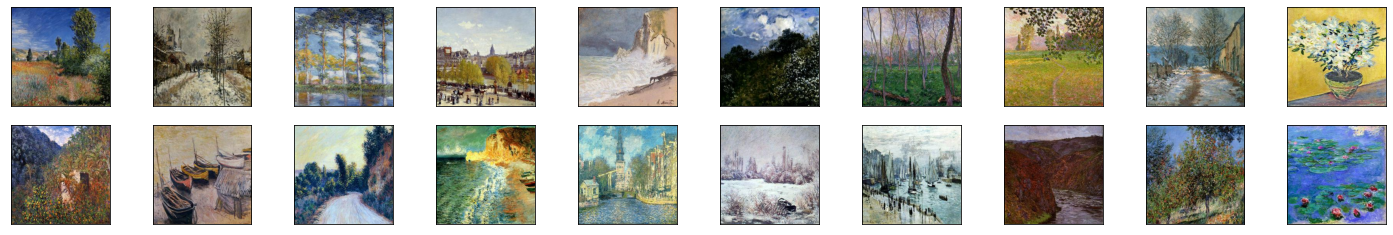

In [38]:
#images of monet from dataloader X
show_dataloader(loader_train_X)

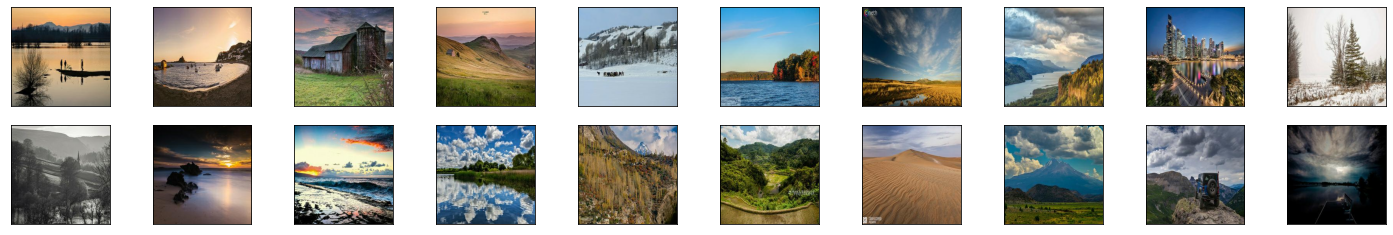

In [39]:
#images of photos from dataloader Y
show_dataloader(loader_train_Y)